# Note

This note continues from [`Experiment_Committee_Series.ipynb`](./Experiment_Committee_Series.ipynb).

In this experiment, we use the modified **logifold package (version 1_4)**.

### Modifications to the logifold package
1. **Entropy measurement**: Before making any prediction, we first measure the entropy of the given instance(s).  
2. **Selective voting**: Based on the measured entropy, we assign which models will participate in voting for each instance.  

Since this modification is first introduced in this experiment, we keep the setup simple.

For instance, we don't need to generate target tree as all targets are simply full and fine.

In [1]:
## load necessary libraries
import os, glob
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from keras.models import load_model
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Model
from scipy.stats import entropy
import math

## logifold
import sys, os
sys.path.append(os.path.abspath('../'))
from logifold_modules.logifoldv1_4_modified import Logifold
from logifold_modules import logifoldv1_4_modified as lgfd


## Modification

In [ ]:
from typing import Sequence
def flatTuple(target,ascending=True):
    out = ()
    for a in target:
        out+=tuple(a)
    if ascending:
        out = tuple(sorted(out))
    return out
class AdvLogifold(Logifold):
    """
    Override of `predict` that:
      - computes per-instance entropy,
      - routes to one of two committees by a threshold,
      - predicts on a single flat 'full-and-fine' target (root only).
    """
    
    def cross_entropy(self, arrays: Sequence[np.ndarray]) -> float:
        """
        Compute  f = - sum_{k != l} sum_{i=1}^m a_{i,k} * log( a_{i,l} )
        where each input is an array of shape (m, 1) (or (m,)).

        Parameters
        ----------
        arrays : sequence of np.ndarray
            N arrays, each of shape (m,1) or (m,). They should all have the same m.
        
        Returns
        -------
        float
            The scalar value of the cross entropy f among the arrays

        Notes
        -----
        - Time complexity is O(m N^2) dominated by the matrix multiply, where N is the length of arrays.
        """
        if len(arrays) == 0:
            return 0.0

        # Stack to shape (m, N)
        cols = [np.asarray(a).reshape(-1) for a in arrays]
        m = cols[0].shape[0]
        if any(c.shape[0] != m for c in cols):
            raise ValueError("All arrays must have the same first dimension m.")
        A = np.column_stack(cols)  # shape (m, N)
        log_base = self.target
        L = np.log(A+1e-12)
        L = L / np.log(log_base) #L= log_base(A)

        M = A.T @ L  # shape (N, N), M[k, l] = sum_i a_{i,k} * log(a_{i,l})
        total = -(np.sum(M) - np.trace(M))  # sum over k != l, then negate
        return float(total)
    def get_entropy_array(self, keys : list, sample_name : str,
                      sample : np.ndarray = None, 
                      preds : dict[str, np.ndarray] = None) -> tuple[np.ndarray, dict[str, np.ndarray]]:
        '''
        param sample: numpy array of (n,) shape
        param preds: dictionary of (raw) predictions from each model in the committee.
        Either sample or preds must be provided. If both sample and preds are provided, preds will be used.
        
        return numpy array of entropy of (n,) shape 
        '''
        if sample is None and preds is None:
            raise ValueError("Either sample or preds must be provided")
        for k in keys:
            if (k, sample_name) not in self.raw_predictions:
                self.raw_predictions[(k, sample_name)] = self.getModel(k).predict(sample,verbose = 0)

        stacked = np.stack([self.raw_predictions[(k, sample_name)] for k in keys], axis=1)

        n = len(stacked)
        
        disagreements = np.zeros(n)
        for i in range(n):
            disagreements[i] = self.cross_entropy(stacked[i,:])

        return disagreements
    def predict(self, 
                x, x_name : str,
                # committees you already have:
                committee_Judge=None,   # list of model keys for low-entropy bucket
                committee_experts=None,  # list of model keys for high-entropy bucket
                entropy_threshold=0.5,
                # keep parent signature defaults for compatibility:
                wantAcc=None, maskInWantAcc=None, keys=None, 
                batch_size: int = 128, force_batch: bool = False, 
                active: bool = True, verbose: int = 0,
                voteBy='weighAcc', onlyFineCanVote: bool = False,
                targetTree=None, keysTree=None, node=(),
                fullAns=None, certPart=None, originalAns=None,
                pred=None, pred_useHist=None, certs=None,
                out=None, modelAcc=None, y=None, reportSeq=None, 
                predOutputFile: str = None, evalOutputFile: str = None,
                show_av_acc: bool = False, show_simple_vote: bool = False, 
                count=0, useHistory=None, write_story: bool = True,
                display_: bool = True):
        """
        Routes inputs by entropy to two committees and predicts on a flat, full target only.
        """
        ## raw prediction should be made by all members once.
        ## raw prediction : key -> (raw) prediction
        if self.raw_predictions is None:
            self.raw_predictions = {}

        # ---  basic safety / defaults ---
        assert voteBy in ('weighAcc', 'order')
        if useHistory is not None and evalOutputFile is not None:
            assert useHistory != evalOutputFile

        if committee_Judge is None or committee_experts is None:
            raise ValueError("Please provide committee_Judge and committee_experts (lists of model keys).")
        keys = list(committee_Judge) + list(committee_experts)
        
        if pred is None: pred = []
        if certs is None: certs = []
        if out is None: out = []
        if modelAcc is None: modelAcc = {}
        if originalAns is None: originalAns = {}
        if wantAcc is None:
            wantAcc = [0.5, 0.7310585786300049, 0.8807970779778823, 0.9525741268224334,
                       0.9820137900379085, 0.9933071490757153, 0.9975273768433653,
                       0.9990889488055994, 0.9996646498695336, 0.9998766054240137]

        assert isinstance(wantAcc, (list, np.ndarray, float))
        if isinstance(wantAcc, float):
            wantAcc = [wantAcc]
        wantAcc = np.array(wantAcc, dtype=float)
        if wantAcc[0] != 0.0:
            wantAcc = np.insert(wantAcc, 0, 0.0)
        # --- build a target tree (root only) ---
        # We want NO recursion / children: the parent will look for nextNodes in keysTree.keys(),
        # and since we only provide {(): ...}, there are no children to traverse.
        
        flat_targetTree = {(): tuple(range(self.target))}
        flat_keysTree_low  = {(): list(committee_Judge)}
        flat_keysTree_high = {(): list(committee_experts)}
        
        # --- compute entropies & build masks ---
        entropy_array = self.get_entropy_array(keys, sample_name = x_name, sample = x)
        if entropy_array.shape[0] != len(x):
            raise ValueError("measure_entropy must return shape (len(x),).")
        mask_low  = (entropy_array <  entropy_threshold)
        mask_high = ~mask_low

        # If everything falls in one bucket, still proceed (other bucket mask will be all False)
        def _expand_mask_per_wantAcc(vec):
            # parent expects `maskInWantAcc` as a list (len=|wantAcc|) of boolean arrays
            return [vec.copy() for _ in range(len(wantAcc))]

        mask_low  = _expand_mask_per_wantAcc(mask_low)
        mask_high = _expand_mask_per_wantAcc(mask_high)

        

        fullAns, certPart, pred, certs, out, originalAns, modelAcc, pred_useHist = super().predict(
            x, x_name,
            wantAcc=wantAcc,
            maskInWantAcc=mask_low,     # process only low-entropy instances in this pass
            keys=list(committee_Judge),
            batch_size=batch_size,
            force_batch=force_batch,
            active=False,               #TODO False -> True (not necessary)
            verbose=verbose,
            voteBy=voteBy,
            onlyFineCanVote=onlyFineCanVote,
            targetTree=flat_targetTree,
            keysTree=flat_keysTree_low,
            node=(),
            fullAns=fullAns,
            certPart=certPart,
            originalAns=originalAns,
            pred=pred,
            pred_useHist=pred_useHist,
            certs=certs,
            out=out,
            modelAcc=modelAcc,
            y=y,
            reportSeq=reportSeq,
            predOutputFile=predOutputFile,
            evalOutputFile=evalOutputFile,
            show_av_acc=show_av_acc,
            show_simple_vote=show_simple_vote,
            count=count,
            useHistory=useHistory,
            write_story=False,          
            display_=display_,
        )

        fullAns, certPart, pred, certs, out, originalAns, modelAcc, pred_useHist = super().predict(
            x, x_name,
            wantAcc=wantAcc,
            maskInWantAcc=mask_high,    # process only high-entropy instances in this pass
            keys=list(committee_experts),
            batch_size=batch_size,
            force_batch=force_batch,
            active=False,
            verbose=verbose,
            voteBy=voteBy,
            onlyFineCanVote=onlyFineCanVote,
            targetTree=flat_targetTree,
            keysTree=flat_keysTree_high,
            node=(),
            fullAns=fullAns,
            certPart=certPart,
            originalAns=originalAns,
            pred=pred,
            pred_useHist=pred_useHist,
            certs=certs,
            out=out,
            modelAcc=modelAcc,
            y=y,
            reportSeq=reportSeq,
            predOutputFile=predOutputFile,
            evalOutputFile=evalOutputFile,
            show_av_acc=show_av_acc,
            show_simple_vote=show_simple_vote,
            count=count,
            useHistory=useHistory,
            write_story=write_story,    # write once after both passes
            display_=display_,
        )

        return fullAns, certPart, pred, certs, out, originalAns, modelAcc, pred_useHist


## Compose Judge 

In [3]:
## predefined dictionary for label
label_dict = {(3,1) : 'ResNet20v1',
        (3,2) : 'ResNet20v2',
        (9,1): 'ResNet56v1',
        (9,2): 'ResNet56v2'}

## load models


# Say 'SB-type', where 'SB' stands for 'Specialized Base'.
folder = 'CIFAR10models/more_tunned/'
pattern = os.path.join(folder, '*_more_specialized*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models = {os.path.basename(f): load_model(f) for f in file_list}

## Compose Committee
Judge_Committee_SB = []
for file_name, model in loaded_models.items():
    # Extract model name from the file name
    base = file_name.replace('.keras','')
    parts = base.split('_')
    # base = ResNet20v1_more_specialized_0, ResNet20v1_once-more_specialized_0, or ResNet20v1_twice-more_specialized_0
    # parts = [ResNet20v1, more, specialized, 0] or [ResNet20v1, once-more, specialized, 0] and so forth.
    if parts[1] != 'more':
        continue
    model_name = parts[0] + '_SB_' + parts[-1]
    Judge_Committee_SB.append((model_name, model))
print(f"Total {len(Judge_Committee_SB)} SB-type models loaded")




Total 20 SB-type models loaded


## Compose Experts Committee

In [4]:
## load specialists


folder = 'specialists/SB/'
pattern = os.path.join(folder, '*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models = {os.path.basename(f): load_model(f) for f in file_list}

## Compose Committee
Specialists_Committee_SB_union = []
Specialists_Committee_SB = []
for file_name, model in loaded_models.items():
    # Extract model name from the file name
    base = file_name.replace('.keras','')
    parts = base.split('_')
    # base = ResNet20v1_SB_4_union_original_PGD_untargeted or ResNet20v1_SB_4_PGD_untargeted
    # parts = [ResNet20v1, SB, #, union, original, PGD, untargeted] or 
    #           [ResNet20v1, SB, #, PGD, untargeted]
    if parts[3] == 'union':
        model_name = parts[0]+f'_SB_{parts[2]}' + '_union_sp'
        Specialists_Committee_SB_union.append((model_name, model))
    else:
        model_name = parts[0] +f'_SB_{parts[2]}'+ '_sp'
        Specialists_Committee_SB.append((model_name, model))

print(f"{len(Specialists_Committee_SB)} specialized models loaded (in each union experts and non-union experts)")


20 specialized models loaded (in each union experts and non-union experts)


## Define entropy thresholds

We'll investigate two $\alpha$: 
- $\alpha$ obtained from PGD validation dataset and 
- $\alpha$ obtained by arithmetic mean of PGD and original validation dataset.

In [5]:
import matplotlib.pyplot as plt

def plot_disagreements(disagreements: np.ndarray | dict[str, np.ndarray], title: str = "Disagreements"):
    '''
    disagreements is either a numpy array of entropies, or a dictionary of entropy whose keys are the name of sample.
    '''
    plt.figure(figsize=(16, 6))
    plt.boxplot(disagreements if isinstance(disagreements, np.ndarray) else list(disagreements.values()))
    plt.title(title)
    if isinstance(disagreements, dict):
        plt.xticks(ticks=range(1, len(disagreements) + 1), labels=list(disagreements.keys()))
    else:
        plt.xlabel("Sample Index")
    plt.ylabel("Disagreement")
    plt.show()
    
def get_statistics(disagreements: np.ndarray) -> dict[str, float]:
    '''
    disagreements is a numpy array of entropies.
    return dictionary of average, median, std, 1Q, 3Q.
    '''
    return {
        "average": float(np.mean(disagreements)),
        "median": float(np.median(disagreements)),
        "std": float(np.std(disagreements)),
        "1Q": float(np.percentile(disagreements, 25)),
        "3Q": float(np.percentile(disagreements, 75)),
    }

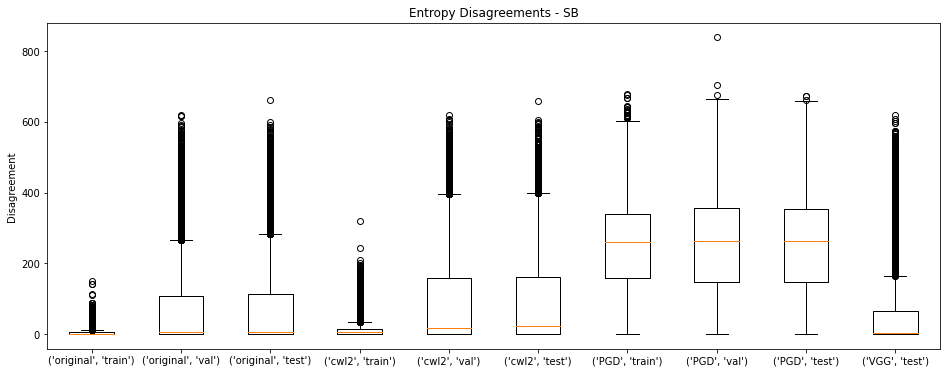

alpha for train: 249.8907037740061, for val: 254.46824986999877
the number of data greater than alpha(PGD):
Training set original + PGD: 0 + 21103 = 21103
Validation set (original, PGD): 1256 + 5241 = 6497
alpha(union) for train: 126.72440127914619, for val: 165.59828443209503
the number of data greater than alpha(union):
Training set original + PGD: 3 + 32649 = 32652
Validation set (original, PGD): 1937 + 7149 = 9086


In [6]:
## With JudgeCommittee_SB, based on the plot: average threshold

import pickle as pkl
## Load entropy arrays from pickle files
with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
    entropy_arrays_SB = pkl.load(f)
## Load raw predictions_SB from pickle files
with open('./data/raw_predictions_SB.pkl', 'rb') as f:
    raw_predictions_SB = pkl.load(f)

plot_disagreements(entropy_arrays_SB, title = "Entropy Disagreements - SB")

# Collect statistics for SB
stats = {}
for key, value in entropy_arrays_SB.items():
    stats[key] = get_statistics(value)

train_alpha_PGD = get_statistics(entropy_arrays_SB[('PGD','train')])['average']
val_alpha_PGD = get_statistics(entropy_arrays_SB[('PGD','val')])['average']

train_alpha_union = (stats[('original','train')]['average'] + stats[('PGD','train')]['average'])/2
val_alpha_union = (stats[('original','val')]['average'] + stats[('PGD','val')]['average'])/2


loc_1_original_train = entropy_arrays_SB[('original','train')]>=train_alpha_PGD
loc_1_PGD_train = entropy_arrays_SB[('PGD','train')]>=train_alpha_PGD
loc_1_original_val = entropy_arrays_SB[('original','val')]>=val_alpha_PGD
loc_1_PGD_val = entropy_arrays_SB[('PGD','val')]>=val_alpha_PGD
print('alpha for train: {}, for val: {}'.format(train_alpha_PGD, val_alpha_PGD))
print('the number of data greater than alpha(PGD):')
print('Training set original + PGD:', np.sum(loc_1_original_train), '+',np.sum(loc_1_PGD_train), '=', np.sum(loc_1_original_train) + np.sum(loc_1_PGD_train))
print('Validation set (original, PGD):', np.sum(loc_1_original_val), '+', np.sum(loc_1_PGD_val), '=', np.sum(loc_1_original_val) + np.sum(loc_1_PGD_val))

loc_1_original_train = entropy_arrays_SB[('original','train')]>=train_alpha_union
loc_1_PGD_train = entropy_arrays_SB[('PGD','train')]>=train_alpha_union
loc_1_original_val = entropy_arrays_SB[('original','val')]>=val_alpha_union
loc_1_PGD_val = entropy_arrays_SB[('PGD','val')]>=val_alpha_union
print('alpha(union) for train: {}, for val: {}'.format(train_alpha_union, val_alpha_union))
print('the number of data greater than alpha(union):')
print('Training set original + PGD:', np.sum(loc_1_original_train), '+',np.sum(loc_1_PGD_train), '=', np.sum(loc_1_original_train) + np.sum(loc_1_PGD_train))
print('Validation set (original, PGD):', np.sum(loc_1_original_val), '+', np.sum(loc_1_PGD_val), '=', np.sum(loc_1_original_val) + np.sum(loc_1_PGD_val))


## Logifolds structures and experiment design

We'll try following type of logifolds

For Judge, train/val = original and for experts, train/val = pgd or union


And we have two expert groups

1. experts on PGD only
2. experts on the union of original and PGD

Remark.

1. getFuzDoms method has key argument x and y.
2. when add a model, key argument fuzDom assigns pre-calculated fuzzy domain.
3. If we remove(key) or remove(keys) then logifold delete everything attached to the keys.
4. Fuzzy domain computation of each model is conducted on its validation set on which they trained/validated.

- Testing dataset will be original/CWL2/VGG/PGD.
- show_av_acc and show_simple_vote 
- use validation history

Baseline1 : only Judge participate (No use of AdvLogifold Prediction structure)

Baseline2 : All models, no use of AdvLogifold prediction

Comparison1 : Judge + Experts(on union)

Comparison2 : Judge + Experts(on PGD)

Comparison3 : Experts(on union) (No use of AdvLogifold)

Comparison4 : Experts(on PGD) (No use of AdvLogifold)



In [7]:
## load datasets

## load CIFAR10 dataset

(x, y), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                              random_state=42) # random state has been always 42.
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_categorical_10 = to_categorical(y_train,10)
y_val_categorical_10 = to_categorical(y_val,10)
y_test_categorical_10 = to_categorical(y_test,10)

## we load only two adversarial samples

import re

pattern = re.compile(r'_\d+to\d+_')

folder = './adversarial_examples/gen_by_ResNet'
all_files = os.listdir(folder)

filtered_files = [
    fname for fname in all_files
    if fname.endswith('.npy') and not pattern.search(fname)]


## load all the training and validation dataset

adv_dataset = {}
import re
for f in filtered_files:
    
    base = f.replace('.keras.npy','').replace('.npy','')
    parts = base.split('_')
    '''
    cwl2_x_tr_untargeted
    cwl2_x_v_untargeted
    cwl2_x_test_untargeted <- gen by ResNet56v1_0
    cwl2_x_test_untargeted_gen_by_ResNet56v1_1
    pgd_0.376_x_untarget
    pgd_0.376_x_val_untarget
    pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10
    '''
    if base in ['cwl2_x_tr_untargeted', 
                'cwl2_x_v_untargeted',
                 'cwl2_x_test_untargeted', 
                #  'cwl2_x_test_untargeted_gen_by_ResNet56v1_1',
                 'pgd_0.376_x_untarget', 
                 'pgd_0.376_x_val_untarget',
                 'pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10']:
        attack_type = parts[0]
        if attack_type == 'cwl2':
            if parts[2] == 'tr':
                train_or_val_or_test = 'train'
            elif parts[2] == 'test':
                train_or_val_or_test = 'test'
            else:
                train_or_val_or_test = 'val'
        else:
            attack_type = 'PGD'
            if parts[3] == 'val':
                train_or_val_or_test = 'val'
            elif parts[3] == 'test':
                train_or_val_or_test = 'test'
            else:
                train_or_val_or_test = 'train'
    else:
        continue
    key = (attack_type, train_or_val_or_test)
    adv_dataset[key] = np.load(os.path.join(folder, f))
    

adv_dataset[('VGG','test')] = np.load('./adversarial_examples/gen_by_VGG/pgd_0.376_x_test_untarget_by_vgg19.npy')
print('-'*50, 'keys for adv samples', '-'*50)
for k in adv_dataset.keys():
    print(k)

''' 
('cwl2', 'val')
('cwl2', 'train')
('PGD', 'val')
('PGD', 'train')
('PGD', 'test')
('cwl2', 'test')
('VGG', 'test')
'''

union_of_train_x = np.concatenate([x_train, adv_dataset[('PGD','train')]])
union_of_train_y = np.concatenate([y_train, y_train])
union_of_val_x = np.concatenate([x_val, adv_dataset[('PGD','val')]])
union_of_val_y = np.concatenate([y_val, y_val])
union_of_test_x = np.concatenate([x_test, adv_dataset[('PGD','test')]])
union_of_test_y = np.concatenate([y_test, y_test])

''' 
adv_dataset[('cwl2','test')]
adv_dataset[('VGG','test')]
'''

-------------------------------------------------- keys for adv samples --------------------------------------------------
('cwl2', 'val')
('cwl2', 'train')
('PGD', 'val')
('PGD', 'train')
('PGD', 'test')
('cwl2', 'test')
('VGG', 'test')


" \nadv_dataset[('cwl2','test')]\nadv_dataset[('VGG','test')]\n"

In [8]:
adversarial_lgfd = AdvLogifold(10, new_story = False, path = './logifolds/exp_committee_series/')

In [9]:
cnt = 0
for member, model in Judge_Committee_SB:
    adversarial_lgfd.add(model, key = (0,cnt), filetype = '.keras',
                         fuzDom = {}, description = f'{member}')
    cnt += 1

cnt = 0
for member, model in Specialists_Committee_SB_union:
    adversarial_lgfd.add(model, key = (1,cnt), filetype = '.keras',
                         fuzDom = {}, description = f'{member}')
    cnt += 1

                         
cnt = 0
for member, model in Specialists_Committee_SB:
    adversarial_lgfd.add(model, key = (2,cnt), filetype = '.keras',
                         fuzDom = {}, description = f'{member}')
    cnt += 1

In [10]:
from IPython.display import display

In [11]:
import pickle as pkl
## Load entropy arrays from pickle files
with open('./data/entropy_arrays_SB.pkl', 'rb') as f:
    entropy_arrays_SB = pkl.load(f)
stats = {}
for key, value in entropy_arrays_SB.items():
    stats[key] = get_statistics(value)

train_alpha_PGD = get_statistics(entropy_arrays_SB[('PGD','train')])['average']
val_alpha_PGD = get_statistics(entropy_arrays_SB[('PGD','val')])['average']

loc_1_PGD_train = entropy_arrays_SB[('PGD','train')]>=train_alpha_PGD
loc_1_PGD_val = entropy_arrays_SB[('PGD','val')]>=val_alpha_PGD

train_alpha_union = (stats[('original','train')]['average'] + stats[('PGD','train')]['average'])/2
val_alpha_union = (stats[('original','val')]['average'] + stats[('PGD','val')]['average'])/2

loc_1_original_train_union = entropy_arrays_SB[('original','train')]>=train_alpha_union
loc_1_PGD_train_union = entropy_arrays_SB[('PGD','train')]>=train_alpha_union
loc_1_original_val_union = entropy_arrays_SB[('original','val')]>=val_alpha_union
loc_1_PGD_val_union = entropy_arrays_SB[('PGD','val')]>=val_alpha_union



In [12]:
adv_dataset[('VGG','val')] = np.load('./adversarial_examples/gen_by_VGG/pgd_0.376_x_val_untarget.npy')
DATASETS = {
    "orig":  dict(val=(x_val, to_categorical(y_val, 10)),
                  test=(x_test, to_categorical(y_test, 10))),
    
    "union": dict(val=(union_of_val_x, to_categorical(union_of_val_y, 10)),
                  test=(union_of_test_x, to_categorical(union_of_test_y, 10))),
    "PGD":   dict(val=(adv_dataset[('PGD','val')],   to_categorical(y_val,   10)),
                  test=(adv_dataset[('PGD','test')], to_categorical(y_test,  10))),
    "cwl2":  dict(val=(adv_dataset[('cwl2','val')],   to_categorical(y_val,   10)),
                  test=(adv_dataset[('cwl2','test')], to_categorical(y_test,  10))),
    "VGG" : dict(val=(adv_dataset[('VGG','val')],   to_categorical(y_val,   10)),
                  test=(adv_dataset[('VGG','test')], to_categorical(y_test,  10))),
    "Judges": dict(train = (x_train, to_categorical(y_train, 10)),
                   val=(x_val, to_categorical(y_val, 10))),
    "Experts_union":dict(train = (np.concatenate([x_train[loc_1_original_train_union], adv_dataset[('PGD','train')][loc_1_PGD_train_union]]), 
                                  to_categorical(
                                      np.concatenate(
                                      [y_train[loc_1_original_train_union], y_train[loc_1_PGD_train_union]]
                                      ), 10)
                                  ),
                         val=(np.concatenate([x_val[loc_1_original_val_union], adv_dataset[('PGD','val')][loc_1_PGD_val_union]]), 
                              to_categorical(
                                  np.concatenate(
                                      [y_val[loc_1_original_val_union], y_val[loc_1_PGD_val_union]]
                                      ),10))),
    "Experts_pgd": dict(train = (adv_dataset[('PGD','train')][loc_1_PGD_train], to_categorical(y_train[loc_1_PGD_train],10)),
                         val=(adv_dataset[('PGD','val')][loc_1_PGD_val], to_categorical(y_val[loc_1_PGD_val],10)))
}

# Note.
# size of Experts pgd : 21103/5241 (tr/val)
# of Experts union : 3+32649/1937+7149 = 32652/9086 (tr/val)


FUZZY_VAL_SOURCES = [
    "Judges",
    "Experts_union",
    "Experts_pgd"
]
alphas = {"PGD": val_alpha_PGD, "union": val_alpha_union}

COMMITTEES = {
    "Judges": dict(keys=[(0, n) for n in range(20)]),                        
    "Experts_union": dict(keys=[(1, n) for n in range(20)]),
    "Experts_pgd": dict(keys=[(2, n) for n in range(20)]),
}

In [13]:
## Compute fuzzy domains

for comm in COMMITTEES.keys():
    x_fuzzy_val, y_fuzzy_val = DATASETS[comm]["val"]
    keys = COMMITTEES[comm]["keys"]
    adversarial_lgfd.getFuzDoms(keys = keys,
                                x = x_fuzzy_val, y = y_fuzzy_val, 
                                update = False, autosave = False, verbose = 0)


Computing fuzzy domains...
The fuzzy domains have been computed.
Computing fuzzy domains...
The fuzzy domains have been computed.
Computing fuzzy domains...
The fuzzy domains have been computed.


In [19]:
alphas

{'PGD': 254.46824986999877, 'union': 165.59828443209503}

In [24]:
def run_once(
             eval_key: str,
             show_tables: bool = False):

    x_val, y_val = DATASETS[eval_key]["val"]
    x_test, y_test = DATASETS[eval_key]["test"]
    x_name = f'{eval_key}'
    def outname(tag):
        return f"{tag}__eval-{eval_key}.csv"

    results = []
    # Baseline 1
    Logifold.predict(
        adversarial_lgfd, x_val, x_name = x_name +'_val',y=y_val,
        keys=COMMITTEES["Judges"]["keys"],
        evalOutputFile=outname("baseline1_val"),
        show_av_acc=True, show_simple_vote=True, write_story=False
    )
    
    base1 = Logifold.predict(
        adversarial_lgfd, x_test, x_name = x_name +'_test', y=y_test,
        keys=COMMITTEES["Judges"]["keys"],
        show_av_acc=True, show_simple_vote=True, write_story=False,
        useHistory = outname("baseline1_val")
    )

    # Baseline 2
    Logifold.predict(
        adversarial_lgfd, x_val, x_name = x_name +'_val',y=y_val,
        evalOutputFile=outname("baseline2_val"),
        show_av_acc=True, show_simple_vote=True, write_story=False
    )
    base2 = Logifold.predict(
        adversarial_lgfd, x_test, x_name = x_name +'_test', y=y_test,
        # keys=None
        show_av_acc=True, show_simple_vote=True, write_story=False,
        useHistory = outname("baseline2_val")
    )

    # Comparison3 and 4 
    def run_fixed(tag, keys_list):
        Logifold.predict(
            adversarial_lgfd, x_val, x_name = x_name +'_val', y=y_val,
            keys=keys_list,
            evalOutputFile=outname(f"{tag}_val"),
            show_av_acc=True, show_simple_vote=True, write_story=False
        )
        
        tst = Logifold.predict(
            adversarial_lgfd, x_test, x_name = x_name +'_test', y=y_test,
            keys=keys_list,
            useHistory=outname(f"{tag}_val"),
            show_av_acc=True, show_simple_vote=True, write_story=False
        )
        return tst

    comp3 = run_fixed("comparison3", COMMITTEES["Experts_union"]["keys"])
    comp4 = run_fixed("comparison4", COMMITTEES["Experts_pgd"]["keys"])

    # --- Routed comparisons using AdvLogifold.predict with custom entropy ---
    # We temporarily monkey-patch an entropy function onto the instance so your
    # AdvLogifold.predict can call it (use it where you compute entropy_array).
    adversarial_lgfd.predict(
        x_val, x_name= x_name + '_val', y=y_val,
        committee_Judge=COMMITTEES["Judges"]["keys"],
        committee_experts=COMMITTEES["Experts_union"]["keys"],
        entropy_threshold=alphas['union'],
        show_av_acc=True, show_simple_vote=True,
        reportSeq=[100],
        evalOutputFile=outname("comparison1_val"),
        write_story=False
    )
    comp1 = adversarial_lgfd.predict(
        x_test, x_name = x_name + '_test', y=y_test,
        committee_Judge=COMMITTEES["Judges"]["keys"],
        committee_experts=COMMITTEES["Experts_union"]["keys"],
        entropy_threshold=alphas["union"],
        show_av_acc=True, show_simple_vote=True,
        reportSeq=[100],
        useHistory=outname(f"comparison1_val"),
        write_story=False
    )
    
    adversarial_lgfd.predict(
        x_val, x_name = x_name + '_val', y=y_val,
        committee_Judge=COMMITTEES["Judges"]["keys"],
        committee_experts=COMMITTEES["Experts_pgd"]["keys"],
        entropy_threshold=alphas['PGD'],
        show_av_acc=True, show_simple_vote=True,
        reportSeq=[100],
        evalOutputFile=outname("comparison2_val"),
        write_story=False
    )
    comp2 = adversarial_lgfd.predict(
        x_test, x_name = x_name + '_test', y=y_test,
        committee_Judge=COMMITTEES["Judges"]["keys"],
        committee_experts=COMMITTEES["Experts_pgd"]["keys"],
        entropy_threshold=alphas['PGD'],
        show_av_acc=True, show_simple_vote=True,
        reportSeq=[100],
        useHistory=outname(f"comparison2_val"),
        write_story=False
    )
    
    
    # --- Collect metrics & optionally show last tables -------------------
    def pick_acc(result):
        # Accuracy by using History
        return result[4][-1][-1]["Accuracy"][-1]

    rows = [
        ("baseline1",         pick_acc(base1)),
        ("baseline2",         pick_acc(base2)),
        ("comparison1",pick_acc(comp1)),
        ("comparison2",pick_acc(comp2)),
        ("comparison3", pick_acc(comp3)),
        ("comparison4", pick_acc(comp4)),
        
    ]
    for name, acc_test in rows:
        results.append({
            "eval_pair": eval_key,
            "run": name,
            "acc_test": float(acc_test),
        })

    if show_tables:
        print(f"[Tables] eval={eval_key}")
        for label, ret in [
            ("baseline1", base1),
            ("baseline2", base2),
            ("comparison1", comp1),
            ("comparison2", comp2),
            ("comparison3", comp3),
            ("comparison4", comp4),
        ]:
            print(label)
            display(ret[4][-1][0])


    return results


In [25]:
all_rows = []

for eval_key in DATASETS.keys():
    if eval_key in COMMITTEES.keys():
        continue
    print(f"\n=== RUN: eval={eval_key} ===")
    rows = run_once(eval_key, show_tables=True)
    all_rows.extend(rows)

summary_df = pd.DataFrame(all_rows).sort_values(
    ["eval_pair", "run"]
)
display(summary_df)
summary_df.to_csv("all_runs_summary.csv", index=False)


=== RUN: eval=orig ===
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
[Tables] eval=orig
baseline1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9408,0.94,0.9407,0.940700,10000
0.500000,0.9408,0.94,0.9407,0.940700,10000
0.731059,0.9408,0.94,0.9407,0.940700,10000
0.880797,0.9408,0.94,0.9407,0.940700,10000
0.952574,0.9408,0.94,0.9415,0.941494,9999
0.982014,0.9408,0.94,0.9408,0.944708,9911
0.993307,0.9408,0.94,0.9396,0.961415,9382
0.997527,0.9408,0.94,0.9410,0.981542,8506
0.999089,0.9408,0.94,0.9408,0.992554,7387
0.999665,0.9408,0.94,0.9407,0.995938,6155


baseline2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9342,0.9347,0.9366,0.936600,10000
0.500000,0.9342,0.9347,0.9366,0.936600,10000
0.731059,0.9342,0.9347,0.9366,0.936600,10000
0.880797,0.9342,0.9347,0.9372,0.937200,10000
0.952574,0.9342,0.9347,0.9373,0.937300,10000
0.982014,0.9342,0.9347,0.9374,0.939552,9959
0.993307,0.9342,0.9347,0.9355,0.950468,9610
0.997527,0.9342,0.9347,0.9377,0.968981,8930
0.999089,0.9342,0.9347,0.9367,0.983677,7964
0.999665,0.9342,0.9347,0.9371,0.986731,7310


comparison1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9376,0.9367,0.9261,0.926100,10000
0.500000,0.9376,0.9367,0.9261,0.926100,10000
0.731059,0.9376,0.9367,0.9261,0.926100,10000
0.880797,0.9376,0.9367,0.9259,0.925900,10000
0.952574,0.9376,0.9367,0.9267,0.932083,9865
0.982014,0.9376,0.9367,0.9248,0.952133,9234
0.993307,0.9376,0.9367,0.9257,0.973748,8304
0.997527,0.9376,0.9367,0.9262,0.987462,7178
0.999089,0.9376,0.9367,0.9261,0.991751,6425
0.999665,0.9376,0.9367,0.9263,0.993919,6085


comparison2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9373,0.9368,0.9245,0.924500,10000
0.500000,0.9373,0.9368,0.9245,0.924500,10000
0.731059,0.9373,0.9368,0.9245,0.924500,10000
0.880797,0.9373,0.9368,0.9234,0.923400,10000
0.952574,0.9373,0.9368,0.9225,0.922838,9992
0.982014,0.9373,0.9368,0.9222,0.932000,9750
0.993307,0.9373,0.9368,0.9236,0.956648,8927
0.997527,0.9373,0.9368,0.9254,0.975350,7992
0.999089,0.9373,0.9368,0.9247,0.986960,6672
0.999665,0.9373,0.9368,0.9250,0.989050,6484


comparison3


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9264,0.9257,0.9261,0.926100,10000
0.500000,0.9264,0.9257,0.9261,0.926100,10000
0.731059,0.9264,0.9257,0.9261,0.926100,10000
0.880797,0.9264,0.9257,0.9259,0.925900,10000
0.952574,0.9264,0.9257,0.9267,0.932083,9865
0.982014,0.9264,0.9257,0.9248,0.952133,9234
0.993307,0.9264,0.9257,0.9257,0.973748,8304
0.997527,0.9264,0.9257,0.9262,0.987462,7178
0.999089,0.9264,0.9257,0.9261,0.991751,6425
0.999665,0.9264,0.9257,0.9263,0.993919,6085


comparison4


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9243,0.9241,0.9245,0.924500,10000
0.500000,0.9243,0.9241,0.9245,0.924500,10000
0.731059,0.9243,0.9241,0.9245,0.924500,10000
0.880797,0.9243,0.9241,0.9234,0.923400,10000
0.952574,0.9243,0.9241,0.9225,0.922838,9992
0.982014,0.9243,0.9241,0.9222,0.932000,9750
0.993307,0.9243,0.9241,0.9236,0.956648,8927
0.997527,0.9243,0.9241,0.9254,0.975350,7992
0.999089,0.9243,0.9241,0.9247,0.986960,6672
0.999665,0.9243,0.9241,0.9250,0.989050,6484



=== RUN: eval=union ===
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
[Tables] eval=union
baseline1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.72355,0.72505,0.72670,0.726700,20000
0.500000,0.72355,0.72505,0.72670,0.726700,20000
0.731059,0.72355,0.72505,0.72670,0.726700,20000
0.880797,0.72355,0.72505,0.72670,0.726700,20000
0.952574,0.72355,0.72505,0.72405,0.724036,19999
0.982014,0.72355,0.72505,0.71355,0.715451,19856
0.993307,0.72355,0.72505,0.68725,0.695111,18797
0.997527,0.72355,0.72505,0.67240,0.676542,16472
0.999089,0.72355,0.72505,0.68640,0.690422,13176
0.999665,0.72355,0.72505,0.70175,0.718750,9984


baseline2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8969,0.8979,0.88630,0.886300,20000
0.500000,0.8969,0.8979,0.88630,0.886300,20000
0.731059,0.8969,0.8979,0.88630,0.886300,20000
0.880797,0.8969,0.8979,0.88490,0.884900,20000
0.952574,0.8969,0.8979,0.87230,0.872300,20000
0.982014,0.8969,0.8979,0.85940,0.860602,19950
0.993307,0.8969,0.8979,0.84575,0.853512,19476
0.997527,0.8969,0.8979,0.83875,0.853210,18380
0.999089,0.8969,0.8979,0.83470,0.854846,16479
0.999665,0.8969,0.8979,0.85315,0.884715,15093


comparison1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.86925,0.86715,0.91710,0.917100,20000
0.500000,0.86925,0.86715,0.91710,0.917100,20000
0.731059,0.86925,0.86715,0.91710,0.917100,20000
0.880797,0.86925,0.86715,0.91680,0.916800,20000
0.952574,0.86925,0.86715,0.91685,0.922309,19745
0.982014,0.86925,0.86715,0.91595,0.945176,18368
0.993307,0.86925,0.86715,0.91750,0.970529,16355
0.997527,0.86925,0.86715,0.91735,0.984745,13963
0.999089,0.86925,0.86715,0.91715,0.990581,12422
0.999665,0.86925,0.86715,0.91730,0.992162,11737


comparison2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.85895,0.8569,0.90985,0.909850,20000
0.500000,0.85895,0.8569,0.90985,0.909850,20000
0.731059,0.85895,0.8569,0.90985,0.909850,20000
0.880797,0.85895,0.8569,0.90960,0.909600,20000
0.952574,0.85895,0.8569,0.90865,0.909237,19975
0.982014,0.85895,0.8569,0.90755,0.919346,19441
0.993307,0.85895,0.8569,0.90915,0.945494,17631
0.997527,0.85895,0.8569,0.91010,0.967398,15551
0.999089,0.85895,0.8569,0.90990,0.982664,12633
0.999665,0.85895,0.8569,0.91015,0.984715,12234


comparison3


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9177,0.91655,0.91710,0.917100,20000
0.500000,0.9177,0.91655,0.91710,0.917100,20000
0.731059,0.9177,0.91655,0.91710,0.917100,20000
0.880797,0.9177,0.91655,0.91680,0.916800,20000
0.952574,0.9177,0.91655,0.91685,0.922309,19745
0.982014,0.9177,0.91655,0.91595,0.945176,18368
0.993307,0.9177,0.91655,0.91750,0.970529,16355
0.997527,0.9177,0.91655,0.91735,0.984745,13963
0.999089,0.9177,0.91655,0.91715,0.990581,12422
0.999665,0.9177,0.91655,0.91730,0.992162,11737


comparison4


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.91045,0.9093,0.90985,0.909850,20000
0.500000,0.91045,0.9093,0.90985,0.909850,20000
0.731059,0.91045,0.9093,0.90985,0.909850,20000
0.880797,0.91045,0.9093,0.90960,0.909600,20000
0.952574,0.91045,0.9093,0.90865,0.909237,19975
0.982014,0.91045,0.9093,0.90755,0.919346,19441
0.993307,0.91045,0.9093,0.90915,0.945494,17631
0.997527,0.91045,0.9093,0.91010,0.967398,15551
0.999089,0.91045,0.9093,0.90990,0.982664,12633
0.999665,0.91045,0.9093,0.91015,0.984715,12234



=== RUN: eval=PGD ===
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
[Tables] eval=PGD
baseline1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.5063,0.5101,0.5127,0.512700,10000
0.500000,0.5063,0.5101,0.5127,0.512700,10000
0.731059,0.5063,0.5101,0.5127,0.512700,10000
0.880797,0.5063,0.5101,0.5127,0.512700,10000
0.952574,0.5063,0.5101,0.5066,0.506600,10000
0.982014,0.5063,0.5101,0.4863,0.486978,9945
0.993307,0.5063,0.5101,0.4349,0.429740,9415
0.997527,0.5063,0.5101,0.4038,0.350866,7966
0.999089,0.5063,0.5101,0.4320,0.304889,5789
0.999665,0.5063,0.5101,0.4628,0.273178,3829


baseline2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8596,0.8611,0.8360,0.836000,10000
0.500000,0.8596,0.8611,0.8360,0.836000,10000
0.731059,0.8596,0.8611,0.8360,0.836000,10000
0.880797,0.8596,0.8611,0.8326,0.832600,10000
0.952574,0.8596,0.8611,0.8073,0.807300,10000
0.982014,0.8596,0.8611,0.7814,0.781904,9991
0.993307,0.8596,0.8611,0.7560,0.759072,9866
0.997527,0.8596,0.8611,0.7398,0.743810,9450
0.999089,0.8596,0.8611,0.7327,0.734351,8515
0.999665,0.8596,0.8611,0.7692,0.788899,7783


comparison1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8009,0.7976,0.9081,0.908100,10000
0.500000,0.8009,0.7976,0.9081,0.908100,10000
0.731059,0.8009,0.7976,0.9081,0.908100,10000
0.880797,0.8009,0.7976,0.9077,0.907700,10000
0.952574,0.8009,0.7976,0.9070,0.912551,9880
0.982014,0.8009,0.7976,0.9071,0.938143,9134
0.993307,0.8009,0.7976,0.9093,0.967209,8051
0.997527,0.8009,0.7976,0.9085,0.981872,6785
0.999089,0.8009,0.7976,0.9082,0.989328,5997
0.999665,0.8009,0.7976,0.9083,0.990269,5652


comparison2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.7806,0.777,0.8952,0.895200,10000
0.500000,0.7806,0.777,0.8952,0.895200,10000
0.731059,0.7806,0.777,0.8952,0.895200,10000
0.880797,0.7806,0.777,0.8958,0.895800,10000
0.952574,0.7806,0.777,0.8948,0.895623,9983
0.982014,0.7806,0.777,0.8929,0.906614,9691
0.993307,0.7806,0.777,0.8947,0.934053,8704
0.997527,0.7806,0.777,0.8948,0.958989,7559
0.999089,0.7806,0.777,0.8951,0.977856,5961
0.999665,0.7806,0.777,0.8953,0.979826,5750


comparison3


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.909,0.9074,0.9081,0.908100,10000
0.500000,0.909,0.9074,0.9081,0.908100,10000
0.731059,0.909,0.9074,0.9081,0.908100,10000
0.880797,0.909,0.9074,0.9077,0.907700,10000
0.952574,0.909,0.9074,0.9070,0.912551,9880
0.982014,0.909,0.9074,0.9071,0.938143,9134
0.993307,0.909,0.9074,0.9093,0.967209,8051
0.997527,0.909,0.9074,0.9085,0.981872,6785
0.999089,0.909,0.9074,0.9082,0.989328,5997
0.999665,0.909,0.9074,0.9083,0.990269,5652


comparison4


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8966,0.8945,0.8952,0.895200,10000
0.500000,0.8966,0.8945,0.8952,0.895200,10000
0.731059,0.8966,0.8945,0.8952,0.895200,10000
0.880797,0.8966,0.8945,0.8958,0.895800,10000
0.952574,0.8966,0.8945,0.8948,0.895623,9983
0.982014,0.8966,0.8945,0.8929,0.906614,9691
0.993307,0.8966,0.8945,0.8947,0.934053,8704
0.997527,0.8966,0.8945,0.8948,0.958989,7559
0.999089,0.8966,0.8945,0.8951,0.977856,5961
0.999665,0.8966,0.8945,0.8953,0.979826,5750



=== RUN: eval=cwl2 ===
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
[Tables] eval=cwl2
baseline1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9347,0.9336,0.9338,0.933800,10000
0.500000,0.9347,0.9336,0.9338,0.933800,10000
0.731059,0.9347,0.9336,0.9338,0.933800,10000
0.880797,0.9347,0.9336,0.9338,0.933800,10000
0.952574,0.9347,0.9336,0.9347,0.934700,10000
0.982014,0.9347,0.9336,0.9321,0.937070,9884
0.993307,0.9347,0.9336,0.9324,0.958496,9204
0.997527,0.9347,0.9336,0.9336,0.979884,8103
0.999089,0.9347,0.9336,0.9339,0.992645,6662
0.999665,0.9347,0.9336,0.9339,0.996723,5188


baseline2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.931,0.9308,0.9328,0.932800,10000
0.500000,0.931,0.9308,0.9328,0.932800,10000
0.731059,0.931,0.9308,0.9328,0.932800,10000
0.880797,0.931,0.9308,0.9333,0.933300,10000
0.952574,0.931,0.9308,0.9340,0.934000,10000
0.982014,0.931,0.9308,0.9322,0.934191,9953
0.993307,0.931,0.9308,0.9301,0.947490,9541
0.997527,0.931,0.9308,0.9322,0.968056,8734
0.999089,0.931,0.9308,0.9336,0.982141,7671
0.999665,0.931,0.9308,0.9334,0.986747,7093


comparison1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9329,0.9327,0.9245,0.924500,10000
0.500000,0.9329,0.9327,0.9245,0.924500,10000
0.731059,0.9329,0.9327,0.9245,0.924500,10000
0.880797,0.9329,0.9327,0.9254,0.925400,10000
0.952574,0.9329,0.9327,0.9255,0.930640,9876
0.982014,0.9329,0.9327,0.9240,0.953337,9215
0.993307,0.9329,0.9327,0.9244,0.974616,8273
0.997527,0.9329,0.9327,0.9247,0.987221,7121
0.999089,0.9329,0.9327,0.9247,0.992006,6380
0.999665,0.9329,0.9327,0.9247,0.993851,6017


comparison2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9333,0.9329,0.9225,0.922500,10000
0.500000,0.9333,0.9329,0.9225,0.922500,10000
0.731059,0.9333,0.9329,0.9225,0.922500,10000
0.880797,0.9333,0.9329,0.9223,0.922300,10000
0.952574,0.9333,0.9329,0.9201,0.920436,9992
0.982014,0.9333,0.9329,0.9208,0.930999,9739
0.993307,0.9333,0.9329,0.9221,0.957540,8879
0.997527,0.9333,0.9329,0.9236,0.974931,7938
0.999089,0.9333,0.9329,0.9229,0.987244,6585
0.999665,0.9333,0.9329,0.9230,0.989195,6386


comparison3


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9255,0.9249,0.9245,0.924500,10000
0.500000,0.9255,0.9249,0.9245,0.924500,10000
0.731059,0.9255,0.9249,0.9245,0.924500,10000
0.880797,0.9255,0.9249,0.9254,0.925400,10000
0.952574,0.9255,0.9249,0.9255,0.930640,9876
0.982014,0.9255,0.9249,0.9240,0.953337,9215
0.993307,0.9255,0.9249,0.9244,0.974616,8273
0.997527,0.9255,0.9249,0.9247,0.987221,7121
0.999089,0.9255,0.9249,0.9247,0.992006,6380
0.999665,0.9255,0.9249,0.9247,0.993851,6017


comparison4


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9239,0.9218,0.9225,0.922500,10000
0.500000,0.9239,0.9218,0.9225,0.922500,10000
0.731059,0.9239,0.9218,0.9225,0.922500,10000
0.880797,0.9239,0.9218,0.9223,0.922300,10000
0.952574,0.9239,0.9218,0.9201,0.920436,9992
0.982014,0.9239,0.9218,0.9208,0.930999,9739
0.993307,0.9239,0.9218,0.9221,0.957540,8879
0.997527,0.9239,0.9218,0.9236,0.974931,7938
0.999089,0.9239,0.9218,0.9229,0.987244,6585
0.999665,0.9239,0.9218,0.9230,0.989195,6386



=== RUN: eval=VGG ===
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
Vote counting...
[Tables] eval=VGG
baseline1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8706,0.8711,0.8712,0.871200,10000
0.500000,0.8706,0.8711,0.8712,0.871200,10000
0.731059,0.8706,0.8711,0.8712,0.871200,10000
0.880797,0.8706,0.8711,0.8712,0.871200,10000
0.952574,0.8706,0.8711,0.8712,0.871287,9999
0.982014,0.8706,0.8711,0.8749,0.877627,9945
0.993307,0.8706,0.8711,0.8725,0.891796,9556
0.997527,0.8706,0.8711,0.8724,0.921305,8857
0.999089,0.8706,0.8711,0.8718,0.949749,7960
0.999665,0.8706,0.8711,0.8711,0.969532,6991


baseline2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9113,0.9112,0.9065,0.906500,10000
0.500000,0.9113,0.9112,0.9065,0.906500,10000
0.731059,0.9113,0.9112,0.9065,0.906500,10000
0.880797,0.9113,0.9112,0.9063,0.906300,10000
0.952574,0.9113,0.9112,0.9034,0.903400,10000
0.982014,0.9113,0.9112,0.9014,0.902153,9985
0.993307,0.9113,0.9112,0.9006,0.908608,9793
0.997527,0.9113,0.9112,0.9034,0.927941,9298
0.999089,0.9113,0.9112,0.9050,0.951311,8544
0.999665,0.9113,0.9112,0.9066,0.966725,7994


comparison1


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9024,0.9013,0.9207,0.920700,10000
0.500000,0.9024,0.9013,0.9207,0.920700,10000
0.731059,0.9024,0.9013,0.9207,0.920700,10000
0.880797,0.9024,0.9013,0.9216,0.921600,10000
0.952574,0.9024,0.9013,0.9198,0.923651,9915
0.982014,0.9024,0.9013,0.9204,0.944130,9361
0.993307,0.9024,0.9013,0.9203,0.964939,8528
0.997527,0.9024,0.9013,0.9203,0.981717,7548
0.999089,0.9024,0.9013,0.9206,0.988379,6798
0.999665,0.9024,0.9013,0.9206,0.990756,6491


comparison2


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.8995,0.8987,0.9170,0.917000,10000
0.500000,0.8995,0.8987,0.9170,0.917000,10000
0.731059,0.8995,0.8987,0.9170,0.917000,10000
0.880797,0.8995,0.8987,0.9164,0.916400,10000
0.952574,0.8995,0.8987,0.9171,0.917334,9992
0.982014,0.8995,0.8987,0.9158,0.926305,9770
0.993307,0.8995,0.8987,0.9170,0.946307,9126
0.997527,0.8995,0.8987,0.9176,0.967322,8293
0.999089,0.8995,0.8987,0.9169,0.984111,7049
0.999665,0.8995,0.8987,0.9168,0.985495,6894


comparison3


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9222,0.92,0.9207,0.920700,10000
0.500000,0.9222,0.92,0.9207,0.920700,10000
0.731059,0.9222,0.92,0.9207,0.920700,10000
0.880797,0.9222,0.92,0.9216,0.921600,10000
0.952574,0.9222,0.92,0.9198,0.923651,9915
0.982014,0.9222,0.92,0.9204,0.944130,9361
0.993307,0.9222,0.92,0.9203,0.964939,8528
0.997527,0.9222,0.92,0.9203,0.981717,7548
0.999089,0.9222,0.92,0.9206,0.988379,6798
0.999665,0.9222,0.92,0.9206,0.990756,6491


comparison4


,acc by taking average,acc by simple vote,acc by refined vote,acc by refined vote restricted on confident domain,size of certain part
0.000000,0.9173,0.9175,0.9170,0.917000,10000
0.500000,0.9173,0.9175,0.9170,0.917000,10000
0.731059,0.9173,0.9175,0.9170,0.917000,10000
0.880797,0.9173,0.9175,0.9164,0.916400,10000
0.952574,0.9173,0.9175,0.9171,0.917334,9992
0.982014,0.9173,0.9175,0.9158,0.926305,9770
0.993307,0.9173,0.9175,0.9170,0.946307,9126
0.997527,0.9173,0.9175,0.9176,0.967322,8293
0.999089,0.9173,0.9175,0.9169,0.984111,7049
0.999665,0.9173,0.9175,0.9168,0.985495,6894


,eval_pair,run,acc_test
12,PGD,baseline1,0.51270
13,PGD,baseline2,0.83600
14,PGD,comparison1,0.90670
15,PGD,comparison2,0.89270
16,PGD,comparison3,0.90670
17,PGD,comparison4,0.89270
24,VGG,baseline1,0.87350
25,VGG,baseline2,0.90310
26,VGG,comparison1,0.91800
27,VGG,comparison2,0.91410


In [26]:
summary_df

,eval_pair,run,acc_test
12,PGD,baseline1,0.51270
13,PGD,baseline2,0.83600
14,PGD,comparison1,0.90670
15,PGD,comparison2,0.89270
16,PGD,comparison3,0.90670
17,PGD,comparison4,0.89270
24,VGG,baseline1,0.87350
25,VGG,baseline2,0.90310
26,VGG,comparison1,0.91800
27,VGG,comparison2,0.91410


###
(untargeted checked)
Targeted try

increasing |f_1 - f_2| direction <-> deep fool method

- entropy -> $C_0$ disagreement
- three directions of adversarial attacks (dissimilarity of derivatives -> $C_1$ disagreement)


On the overlapping region, logifold is not perfect, and we want it to be $C_0$ agreeing.


........Filter

Exp1gp....Exp2gp....

Ent1......Ent2......

Disagreement of each group is well-defined, and in each node they agree $C_0$ sense (ideally).



(optional)

Get sample with much bigger perturbation, and then try.


Single model trained on union (original + PGD) (specialize once more)

Single model trained on original, specialize on the union
